__Preprocess 1: Image__

The image is the image of your strong lens - most likely a co-add of multiple dithered exposures.

Throughout all these tutorials, we'll refer to a "pixel_scale" when loading data. The pixel-scale describes the
pixel-units to arcsecond-units conversion factor of your telescope, which you should look up now if you are unsure
of the value. HST `Imaging` typically has a pixel_scale of 0.05", however this varies depending on the detector and
data reduction procedure so DOUBLE CHECK THIS!

This tutorial describes preprocessing your dataset`s image to adhere too the units and formats required by PyAutoLens.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

#%matplotlib inline
from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


Setup the path the datasets we'll use to illustrate preprocessing, which is the folder `dataset/imaging/preprocess`.

In [2]:
dataset_path = path.join("dataset", "imaging", "preprocess")

__Loading Data From Individual Fits Files__

First, lets load an image as an Array2D. This image represents a good data-reduction that conforms to the formatting 
standards I describe in this tutorial!

In [3]:
imaging_path = path.join(dataset_path, "imaging")

image = al.Array2D.from_fits(
    file_path=path.join(imaging_path, "image.fits"), pixel_scales=0.1
)

There are numerous reasons why the image below is a good data-set for lens modeling. I strongly recommend 
you adapt your data reduction pipelines to conform to the formats discussed below - it`ll make your time using 
PyAutoLens a lot simpler.

However, you may not have access to the data-reduction tools that made the data, so we've included in-built functions 
in PyAutoLens to convert the data to a suitable format.

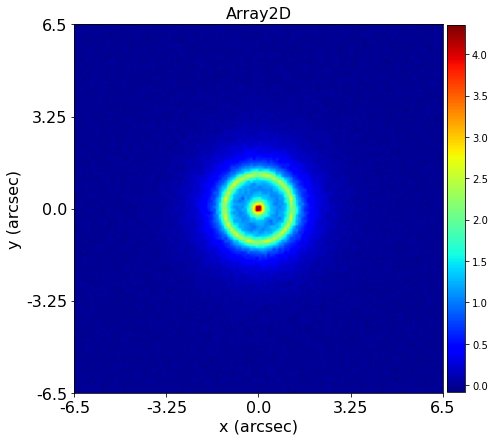

In [4]:
array_plotter = aplt.Array2DPlotter(array=image)
array_plotter.figure()

__1) Converting Data To Electrons Per Second__

1) Brightness units - the image`s flux values should be in units of electrons per second (as opposed to electrons, 
counts, ADU`s etc.). Although PyAutoLens can technically perform an analysis using other units, the default setup 
assumes electrons per second (e.g. the priors on `LightProfile` intensity and `Regularization` parameters). Thus, images 
not in electrons per second should be converted!

Lets look at an image that is in units of counts - its easy to tell because the peak values are in the 1000`s or 10000`s.

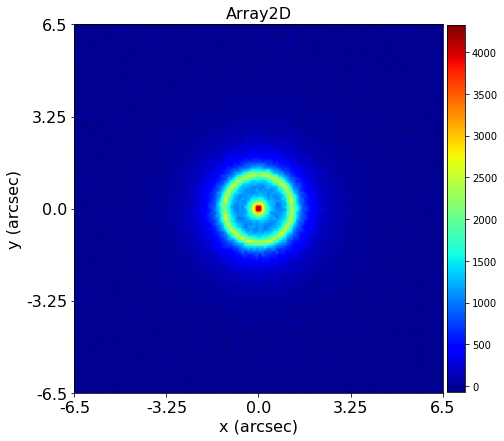

In [5]:
imaging_path = f"{dataset_path}/imaging_in_counts"

image_in_counts = al.Array2D.from_fits(
    file_path=path.join(imaging_path, "image.fits"), pixel_scales=0.1
)

array_plotter = aplt.Array2DPlotter(array=image_in_counts)
array_plotter.figure()

Converting from counts to electrons per second means we must know the exposure time of our observation, which should be
an output of your data reduction pipeline.

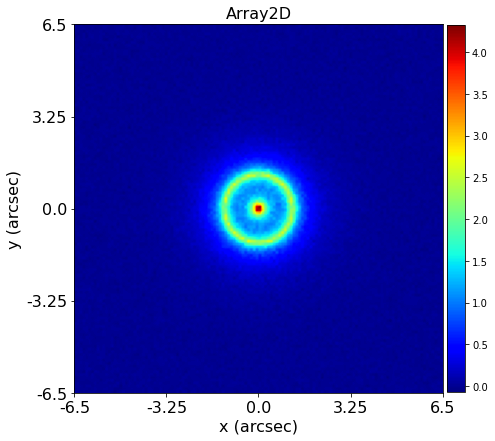

In [6]:
exposure_time = 1000.0

exposure_time_map = al.Array2D.full(
    fill_value=exposure_time,
    shape_native=image_in_counts.shape_native,
    pixel_scales=image_in_counts.pixel_scales,
)

image_converted_to_eps = al.preprocess.array_counts_to_eps(
    array_counts=image_in_counts, exposure_time_map=exposure_time_map
)

array_plotter = aplt.Array2DPlotter(array=image_converted_to_eps)
array_plotter.figure()

If the effective exposure-time map is output as part of the data reduction, you can use this to convert the image to 
electrons per second instead.

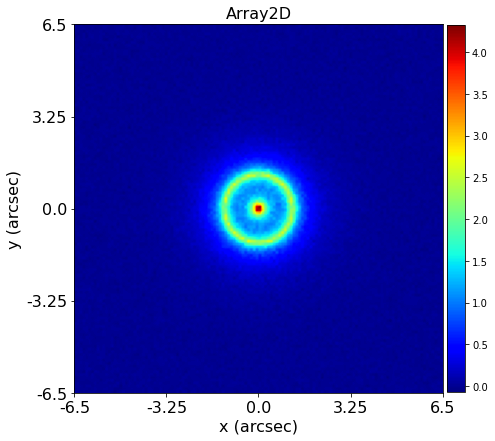

In [7]:
exposure_time_map = al.Array2D.from_fits(
    file_path=f"{imaging_path}/exposure_time_map.fits",
    pixel_scales=image_converted_to_eps.pixel_scales,
)

image_converted_to_eps = al.preprocess.array_counts_to_eps(
    array_counts=image_in_counts, exposure_time_map=exposure_time_map
)

array_plotter = aplt.Array2DPlotter(array=image_converted_to_eps)
array_plotter.figure()

PyAutoLens can also convert data from units of ADUs to electrons per second, which uses both the exposure time and
instrumental gain of the data.

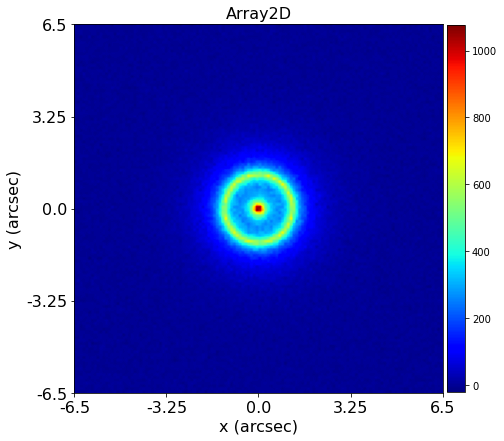

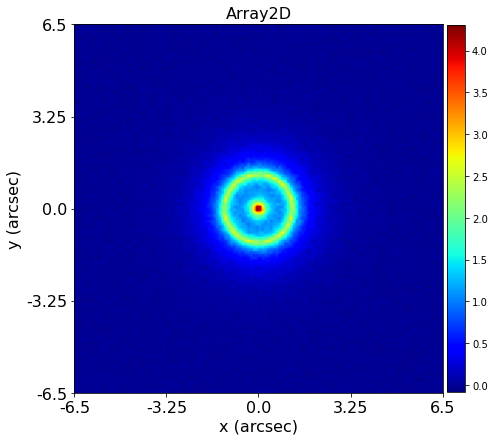

In [8]:
imaging_path = f"{dataset_path}/imaging_in_adus"

image_in_adus = al.Array2D.from_fits(
    file_path=path.join(imaging_path, "image.fits"), pixel_scales=0.1
)

array_plotter = aplt.Array2DPlotter(array=image_in_adus)
array_plotter.figure()

exposure_time_map = al.Array2D.full(
    fill_value=1000.0,
    shape_native=image_in_counts.shape_native,
    pixel_scales=image_in_adus.pixel_scales,
)

image_converted_to_eps = al.preprocess.array_adus_to_eps(
    array_adus=image_in_adus, exposure_time_map=exposure_time_map, gain=4.0
)

array_plotter = aplt.Array2DPlotter(array=image_converted_to_eps)
array_plotter.figure()

In `autolens_workspace/notebooks/preprocess/prepare/noise_map.py` we show that a noise-map must also be in units of electrons 
per second, and that the same functions as above can be used to do this.

2)__Resizing Data__

The bigger the postage stamp cut-out of the image the more memory it requires to store. Visualization will be less 
ideal too, as the lens will be a small blob in the centre relative to the large surrounding edges of the image. Why 
keep the edges surrounding the lens if they are masked out anyway?

Lets look at an example of a very large postage stamp - we can barely even see the lens and source galaxies!

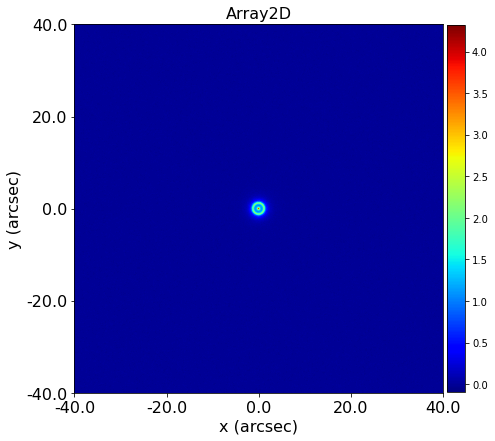

In [9]:
imaging_path = f"{dataset_path}/imaging_with_large_stamp"

image_large_stamp = al.Array2D.from_fits(
    file_path=path.join(imaging_path, "image.fits"), pixel_scales=0.1
)

array_plotter = aplt.Array2DPlotter(array=image_large_stamp)
array_plotter.figure()

If you have a large postage stamp you can trim it using the preprocess module. Trimming is centred on the image.

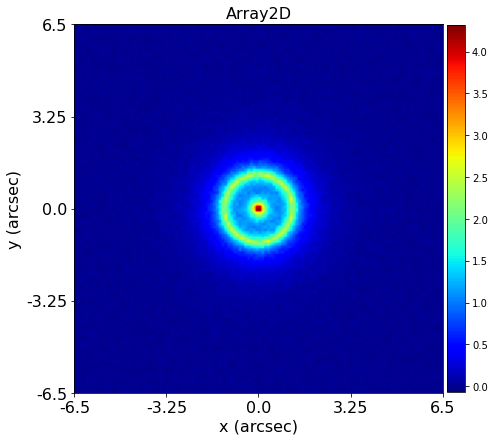

In [10]:
image_large_stamp_trimmed = al.preprocess.array_with_new_shape(
    array=image_large_stamp, new_shape=(130, 130)
)

array_plotter = aplt.Array2DPlotter(array=image_large_stamp_trimmed)
array_plotter.figure()

The stamp may also be too small. It must have sufficient padding around the border that our mask includes all 
pixels with signal. More importantly, the padding must also stretch into the `blurring region`, corresponding to all 
unmasked image pixels where light blurs into the masks after PSF convolution. Thus, we may need to pad an image to 
include_2d this region.

In [11]:
imaging_path = f"{dataset_path}/imaging_with_small_stamp"

This image is an example of a stamp which is big enough to contain the lens and source galaxies, but when we apply a 
sensible masks we get an error, because the masks`s blurring region goes into the edge of the image.

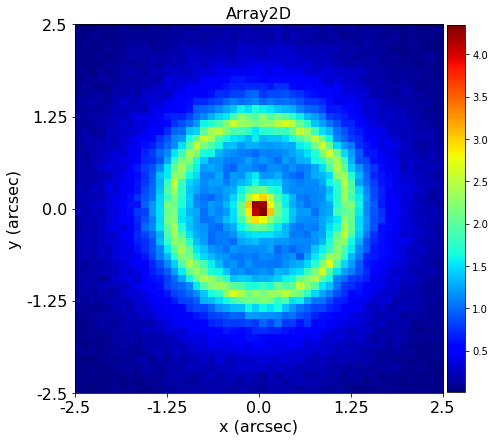

In [12]:
image_small_stamp = al.Array2D.from_fits(
    file_path=path.join(imaging_path, "image.fits"), pixel_scales=0.1
)

array_plotter = aplt.Array2DPlotter(array=image_small_stamp)
array_plotter.figure()

If we apply a masks to this image we get an error when we try to use it to set up a masked image because its 
blurring region (defined by the PSF kernel shape) hits the image edge.

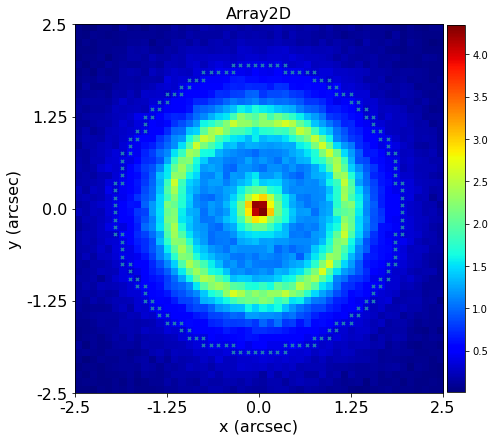

In [13]:
mask = al.Mask2D.circular(
    shape_native=image_small_stamp.shape_native,
    pixel_scales=image_small_stamp.pixel_scales,
    radius=2.0,
)

visuals_2d = aplt.Visuals2D(mask=mask)

array_plotter = aplt.Array2DPlotter(array=image_small_stamp, visuals_2d=visuals_2d)
array_plotter.figure()

The setup of the Convolver (used to perform PSF blurring in a PyAutoLens analysis) now gives an error because the 
mask`s edge and therefore blurring region goes over the edge of the edge.

In [14]:
# convolver = al.Convolver(mask=mask, kernel=al.Kernel2D.ones(shape_native=(31, 31)))

We overcome this using the same function as before. However, the resized image shape now becomes bigger than the 
image, by padding zeros at the edges.

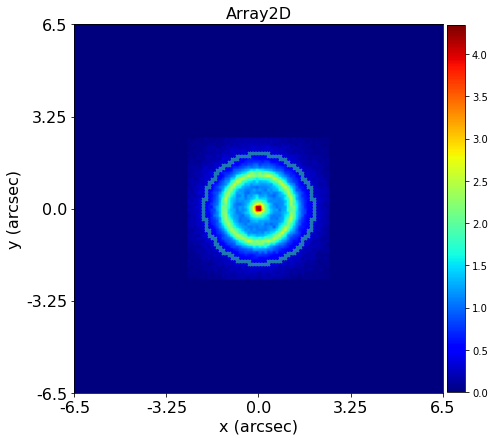

In [15]:
image_small_stamp_padded = al.preprocess.array_with_new_shape(
    array=image_small_stamp, new_shape=(130, 130)
)

mask = al.Mask2D.circular(
    shape_native=image_small_stamp_padded.shape_native,
    pixel_scales=image_small_stamp_padded.pixel_scales,
    radius=2.0,
)

visuals_2d = aplt.Visuals2D(mask=mask)

array_plotter = aplt.Array2DPlotter(
    array=image_small_stamp_padded, visuals_2d=visuals_2d
)
array_plotter.figure()

This no longer gives an error!

In [16]:
convolver = al.Convolver(
    mask=mask,
    kernel=al.Kernel2D.ones(shape_native=(31, 31), pixel_scales=mask.pixel_scales),
)

# 3) ``.entering__

########## IVE INCLUDED THE TEXT CAN BE AWARE OF CENTERING, BUT THE BUILT IN FUNCTIONALITY FOR #####
########## RECENTERING CURRENTLY DOES NOT WORK :( ###########

# Lens Galaxy Centering - The lens galaxy should be in the centre of the image as opposed to a corner. This ensures
# the origin of the lens galaxy's light and `MassProfile`'s are near the origin (0.0", 0.0") of the grid used to perform
# ray-tracing. The defaults priors on light and `MassProfile`'s assume a origin of (0.0", 0.0").

# Lets look at an off-center image - clearly both the lens galaxy and Einstein ring are offset in the positive y and x d
# directions.

# imaging_path = f"{dataset_path}/imaging_offset_centre"

# imaging_offset_centre = al.Imaging.from_fits(image_path=path+`image.fits`, pixel_scales=0.1,
#                                   noise_map_path=path+`noise_map.fits`,
#                                   psf_path=path+`psf.fits`)
# aplt.Imaging.subplot(imaging=imaging_offset_centre)

# We can address this by using supplying a new centre for the image, in pixels. We also supply the resized shape, to
# instruct the code whether it should trim the image or pad the edges that now arise due to recentering.

# imaging_recentred_pixels = al.Imaging.from_fits(image_path=path+`image.fits`, pixel_scales=0.1,
#                                             noise_map_path=path+`noise_map.fits`,
#                                             psf_path=path+`psf.fits`,
#                                             resized_imaging_shape=(100, 100),
#                                             resized_imaging_centre_pixels=(0, 0))
# #                                            resized_imaging_centre_arc_seconds=(1.0, 1.0))
# print(imaging_recentred_pixels.shape)
